<a href="https://colab.research.google.com/github/kaptenHANDOYO17/MIDTERM-AI-HANDOYO-21120124120040-KELAS-C/blob/main/TRAINING_4_VARIANS_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example: train SB3 DQN for a short run (B-tier).
Example: train manual DQN variants (short runs).

--- Training variant: dqn
[dqn] Episode 10/500  steps=2812  ep_reward=-410.68  avg10=-364.07
[dqn] Episode 20/500  steps=5867  ep_reward=-326.83  avg10=-408.06
[dqn] Episode 30/500  steps=8258  ep_reward=-444.90  avg10=-330.26
[dqn] Episode 40/500  steps=11087  ep_reward=-531.98  avg10=-381.12
[dqn] Episode 50/500  steps=14665  ep_reward=-421.92  avg10=-437.19
[dqn] Episode 60/500  steps=18072  ep_reward=-539.54  avg10=-395.37
[dqn] Episode 70/500  steps=20773  ep_reward=-427.22  avg10=-313.65
[dqn] Episode 80/500  steps=24007  ep_reward=-504.56  avg10=-286.42
[dqn] Episode 90/500  steps=27864  ep_reward=-246.39  avg10=-352.27
[dqn] Episode 100/500  steps=31639  ep_reward=-314.55  avg10=-369.78
[dqn] Episode 110/500  steps=35382  ep_reward=-288.36  avg10=-299.71
[dqn] Episode 120/500  steps=38469  ep_reward=-223.70  avg10=-273.66
[dqn] Episode 130/500  steps=41306  ep_reward=-227.50  avg1

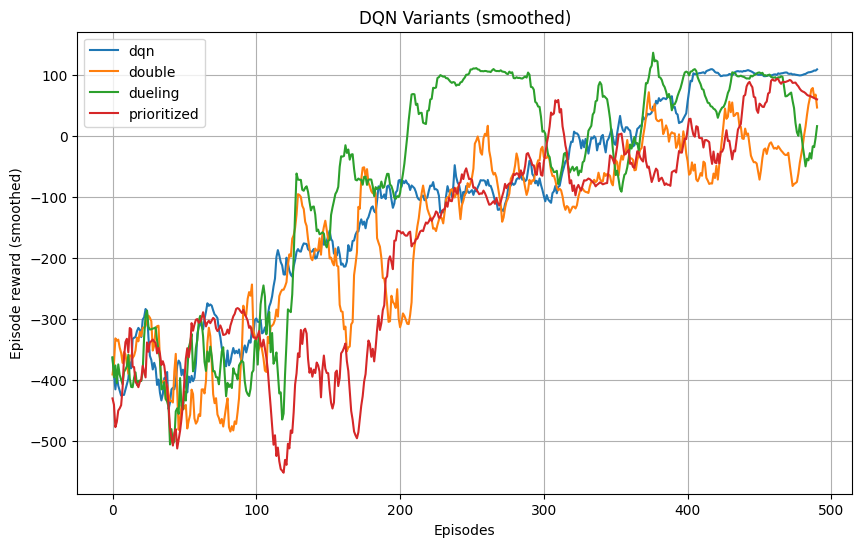

Done. Save models or increase training length for production experiments.


In [ ]:
# Colab-friendly combined script for Rocket RL (Stable-Baselines3 + PyTorch manual DQN variants)
# Pastikan jalankan di Google Colab runtime (GPU recommended for PyTorch training)

# 0) Install dependencies (run once)
!pip install -q gymnasium pygame stable-baselines3[extra] torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
# Note: if you want GPU torch, change the install to match CUDA version. Above installs CPU build for simplicity.

# 1) Import libs
import os, random, math, time, copy
from collections import deque, namedtuple
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
import pygame

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For stable-baselines3
from stable_baselines3 import DQN as SB3_DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.atari_wrappers import ClipRewardEnv

# -------------------------
# 2) Environment (fixed + reward redesign)
# -------------------------
class SimpleRocketEnv(gym.Env):
    """
    Adapted from user-provided code. Main changes:
      - deterministic target movement (no random per-step tvx)
      - robust reward shaping (see _compute_reward)
      - clearer landing detection
      - normalizer preserved
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode
        # Simulation params
        self.dt, self.m, self.g = 0.025, 3.0, 9.81
        self.F_main, self.F_side = 400.0, 200.0

        # Screen & world
        self.screen_w, self.screen_h = 960, 480
        self.floor_y = 10.0

        # Rocket geometry & inertia
        self.w, self.h = 30.0, 60.0
        self.I = (1/12) * self.m * (self.w**2 + self.h**2)

        # Damping
        self.b_linear  = 0.1
        self.b_angular = 0.05

        # Target rectangle center + size
        tx_init = int(random.random() * 500)
        self.target_pos = np.array([300.0 + tx_init, 40.0], np.float32)
        self.target_w, self.target_h = 240.0, 80.0
        self.target_min_x = 300.0
        self.target_max_x = 800.0
        self.target_speed = 50.0  # units per second

        # Launch pad center in world coords and dim
        self.launch_pad_pos = np.array([100.0, 50.0], dtype=np.float32)
        self.pad_w, self.pad_h = 40.0, 40.0

        # Observation: x, y, vx, vy, sinθ, cosθ, ω, dx, dy
        high = np.array([
            self.screen_w, self.screen_h,
            np.finfo(np.float32).max, np.finfo(np.float32).max,
            1., 1.,
            20.,
            self.screen_w, self.screen_h
        ], np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.action_space      = spaces.Discrete(4)

        # rendering
        self.render_mode = render_mode
        if self.render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_w, self.screen_h))
            pygame.display.set_caption("Simple Rocket Env")
            self.clock = pygame.time.Clock()
            self.font  = pygame.font.SysFont("Arial", 16)
            # load images if provided in working dir
            base = os.getcwd()
            try:
                rocket_path = os.path.join(base, "rocket.png")
                target_path = os.path.join(base, "target.png")
                self.rocket_img = pygame.transform.scale(pygame.image.load(rocket_path).convert_alpha(), (int(self.w), int(self.h)))
                self.target_img = pygame.transform.scale(pygame.image.load(target_path).convert_alpha(),
                                                    (int(self.target_w), int(self.target_h)))
            except Exception:
                # fallback: simple surfaces
                self.rocket_img = pygame.Surface((int(self.w), int(self.h)), pygame.SRCALPHA)
                pygame.draw.polygon(self.rocket_img, (200,200,255), [(self.w/2,0),(self.w, self.h),(0,self.h)])
                self.target_img = pygame.Surface((int(self.target_w), int(self.target_h)))
                self.target_img.fill((120,120,200))

        self.state = None
        self.last_action = 0
        self.max_steps = 800
        self.step_count = 0

        # reward params
        self.success_bonus = 200.0
        self.crash_penalty = -100.0
        self.target_crash_penalty = -50.0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        # Start upright, zero velocity
        x0 = self.launch_pad_pos[0] + random.uniform(-5,5)
        y0 = self.launch_pad_pos[1] + random.uniform(-1,1)
        self.state = np.array([x0, y0, 0., 20. + random.uniform(-5,5), 0., 1., 0., 0., 0.], np.float32) / self._normalizer()
        # randomize target velocity direction
        self.target_vx = self.target_speed * random.choice([1,-1])
        self.last_action = 0
        self.step_count = 0
        return self.state, {}

    def step(self, action):
        self.step_count += 1

        x, y, vx, vy, sinθ, cosθ, ω, dx, dy = self.state * self._normalizer()
        Fx = Fy = torque = 0.0
        θ = math.atan2(sinθ, cosθ)

        # Main or side thrusters
        if action == 1:
            Fx = self.F_main * math.sin(θ)
            Fy = self.F_main * math.cos(θ)
        elif action in (2, 3):
            s = 1 if action == 2 else -1
            torque = s * self.F_side * (self.h/2)
            Fx += -s * self.F_side * math.cos(θ)
            Fy += -s * self.F_side * math.sin(θ)

        # add linear drag
        Fx += -self.b_linear * vx
        Fy += -self.b_linear * vy
        torque += -self.b_angular * ω

        # integrate translational motion
        vy += ((Fy/self.m) - self.g) * self.dt
        vx += (Fx/self.m) * self.dt
        y  += vy * self.dt
        x  += vx * self.dt

        # integrate rotational motion
        ω += (torque / self.I) * self.dt
        θ += ω * self.dt
        sinθ, cosθ = math.sin(θ), math.cos(θ)

        # clamp
        θ = (θ + math.pi) % (2*math.pi) - math.pi
        vx, vy = np.clip([vx, vy], -120, 120)
        ω = np.clip(ω, -20, 20)

        # update target position deterministically
        tx, ty = self.target_pos
        tx += self.target_vx * self.dt
        if tx < self.target_min_x:
            tx = self.target_min_x
            self.target_vx = -self.target_vx
        elif tx > self.target_max_x:
            tx = self.target_max_x
            self.target_vx = -self.target_vx
        self.target_pos[0] = tx

        dx = x - self.target_pos[0]
        dy = y - self.target_pos[1]

        # Floor collision
        landed = False
        if y <= self.floor_y:
            y, vy = self.floor_y, 0.0
            landed = True

        # Target collision (bounding box)
        tx, ty = self.target_pos
        half_w, half_h = self.target_w/2, self.target_h/2
        target_collide = (tx-half_w<=x<=tx+half_w) and (ty-half_h<=y<=ty+half_h)

        # Compute reward with shaping
        reward, success = self._compute_reward(x,y,vx,vy,θ,target_collide,action)

        # terminal conditions
        terminated = False
        if success:
            terminated = True
        elif target_collide and not success:
            # crash on target - treat as terminal
            terminated = True
        elif x<0 or x>self.screen_w or y>self.screen_h:
            reward += self.crash_penalty
            terminated = True
        elif landed and not target_collide:
            reward += self.crash_penalty
            terminated = True

        truncated = False
        if self.step_count >= self.max_steps:
            truncated = True

        self.state = np.array([x, y, vx, vy, math.sin(θ), math.cos(θ), ω, dx, dy], np.float32) / self._normalizer()
        self.last_action = action

        return self.state, float(reward), bool(terminated), bool(truncated), {}

    def _compute_reward(self, x, y, vx, vy, θ, target_collide, action):
        # distances
        tx, ty = self.target_pos
        dist = math.hypot(x - tx, y - ty)
        max_dist = math.hypot(self.screen_w, self.screen_h)
        r_dist = - (dist / max_dist) * 1.0

        # upright reward: cos(theta) -> 1 when upright
        r_upright = math.cos(θ)

        # velocity penalty (normalized)
        vx_max, vy_max = 120.0, 120.0
        r_vel = - (abs(vx)/vx_max + abs(vy)/vy_max)

        # small penalty on using thruster to encourage efficiency
        r_action_pen = -0.01 if action != 0 else 0.0

        # accumulate
        base = 1.5 * r_dist + 0.8 * r_upright + 1.0 * r_vel + r_action_pen

        # terminal rewards
        success = False
        # thresholds for safe landing
        vy_thresh = 6.0
        vx_thresh = 6.0
        theta_thresh = 0.35  # ~20 degrees

        if target_collide:
            # check safe criteria
            if abs(vy) <= vy_thresh and abs(vx) <= vx_thresh and abs(θ) <= theta_thresh:
                base += self.success_bonus
                success = True
            else:
                base += self.target_crash_penalty

        return base, success

    def _normalizer(self):
        return np.array([self.screen_w, self.screen_h, 120., 120., 1., 1., 20., self.screen_w, self.screen_h])

    def render(self, mode='human'):
        if mode != 'human':
            return
        x, y, vx, vy, sinθ, cosθ, ω, dx, dy = self.state * self._normalizer()
        self.screen.fill((0,0,0))
        y_flip = self.screen_h - y
        θ = math.atan2(sinθ, cosθ)

        # Draw rocket sprite rotated to match physics angle
        deg = -np.degrees(θ)
        rocket = pygame.transform.rotate(self.rocket_img, deg)
        rect = rocket.get_rect(center=(x, y_flip))
        self.screen.blit(rocket, rect.topleft)

        # Draw thrust flame
        if self.last_action == 1:
            flame = [(-5,self.h/2), (5,self.h/2), (0,self.h/2+20)]
        elif self.last_action in (2,3):
            s = -1 if self.last_action==2 else 1
            flame = [(s*(self.w/2+5),0), (s*self.w/2,-5), (s*self.w/2,5)]
        else:
            flame = []
        if flame:
            c, s_ = math.cos(θ), math.sin(θ)
            pts = [(int(x + c*px - s_*py), int(y_flip + s_*px + c*py)) for px,py in flame]
            pygame.draw.polygon(self.screen, (255,140,70), pts)

        # Floor & target
        fy = self.screen_h - self.floor_y
        pygame.draw.line(self.screen,(200,200,200),(0,fy),(self.screen_w,fy),2)

        tx, ty = self.target_pos
        tx, ty = tx-self.target_w/2, (self.screen_h-ty)-self.target_h/2
        self.screen.blit(self.target_img, (int(tx), int(ty)))

        # Pad
        px, py = self.launch_pad_pos
        screen_py = self.screen_h - py
        pad_rect = pygame.Rect(int(px - self.pad_w/2), int(screen_py), int(self.pad_w), int(self.pad_h))
        pygame.draw.rect(self.screen, (80, 120, 80), pad_rect)

        # HUD
        info = f"x={x:.1f} y={y:.1f} vx={vx:.1f} vy={vy:.1f} θ={θ:.2f} ω={ω:.2f} dx={dx:.1f} dy={dy:.1f}"
        self.screen.blit(self.font.render(info, True, (255,255,255)), (10,10))

        pygame.display.flip()
        self.clock.tick(50)

    def close(self):
        try:
            if self.render_mode == 'human':
                pygame.quit()
        except Exception:
            pass

# -------------------------
# 3) Utils: wrappers and helpers
# -------------------------
def make_env(render_mode=None):
    return SimpleRocketEnv(render_mode=render_mode)

# A helper to evaluate a policy
def evaluate_policy(policy_fn, env, episodes=5, render=False):
    rewards = []
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0.0
        while True:
            if render:
                env.render()
            a = policy_fn(np.array(s, dtype=np.float32))
            s, r, term, trunc, info = env.step(int(a))
            total += r
            if term or trunc:
                break
        rewards.append(total)
    return np.mean(rewards), rewards

# -------------------------
# 4) Stable-Baselines3 baseline (B-tier)
# -------------------------
def train_sb3(total_timesteps=50000, save_path="sb3_dqn_rocket"):
    env = DummyVecEnv([lambda: make_env(render_mode=None)])
    # optional normalization
    # env = VecNormalize(env, norm_reward=False, clip_obs=1e6)
    model = SB3_DQN("MlpPolicy", env,
                    learning_rate=1e-4,
                    buffer_size=50000,
                    learning_starts=1000,
                    batch_size=64,
                    tau=1.0,
                    gamma=0.99,
                    train_freq=4,
                    target_update_interval=1000,
                    verbose=1)
    model.learn(total_timesteps=total_timesteps)
    os.makedirs(save_path, exist_ok=True)
    model.save(os.path.join(save_path, "model"))
    return model

# -------------------------
# 5) Manual DQN in PyTorch (AB-tier + A-tier variants)
# -------------------------
# Network architectures
class QNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc_v = nn.Linear(hidden, hidden)
        self.fc_a = nn.Linear(hidden, hidden)
        self.v_out = nn.Linear(hidden, 1)
        self.a_out = nn.Linear(hidden, n_actions)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        v = F.relu(self.fc_v(h))
        a = F.relu(self.fc_a(h))
        v = self.v_out(v)
        a = self.a_out(a)
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

# Replay buffer (regular)
Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

# Prioritized replay (simple proportional)
class PrioritizedReplay:
    def __init__(self, capacity=100000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = []
        self.pos = 0
    def push(self, *args, error=1.0):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
            self.priorities.append(None)
        self.buffer[self.pos] = Transition(*args)
        self.priorities[self.pos] = (abs(error) + 1e-6) ** self.alpha
        self.pos = (self.pos + 1) % self.capacity
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            raise IndexError
        # Ensure priorities are non-negative before summing
        priorities = np.maximum(self.priorities, 0)
        total_priority = sum(priorities)
        if total_priority == 0:
             # Handle case where all priorities are zero
             probs = np.ones(len(self.buffer)) / len(self.buffer)
        else:
             probs = priorities / total_priority

        idxs = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in idxs]
        weights = (len(self.buffer) * probs[idxs]) ** (-beta)
        weights /= weights.max()
        return Transition(*zip(*samples)), idxs, torch.tensor(weights, dtype=torch.float32)
    def update_priorities(self, idxs, errors):
        for i, e in zip(idxs, errors):
            self.priorities[i] = (abs(e) + 1e-6) ** self.alpha
    def __len__(self):
        return len(self.buffer)

# DQN trainer supporting variants
def train_dqn_variant(variant='dqn', num_episodes=1000, batch_size=64, gamma=0.99, lr=1e-4,
                      buffer_size=50000, target_update_freq=1000, max_steps_per_episode=800, device='cpu'):
    """
    variant: 'dqn', 'double', 'dueling', 'prioritized'
    """
    env = make_env(render_mode=None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    # choose network
    if variant == 'dueling':
        online_net = DuelingQNetwork(obs_dim, n_actions).to(device)
        target_net = DuelingQNetwork(obs_dim, n_actions).to(device)
    else:
        online_net = QNetwork(obs_dim, n_actions).to(device)
        target_net = QNetwork(obs_dim, n_actions).to(device)

    target_net.load_state_dict(online_net.state_dict())
    optimizer = optim.Adam(online_net.parameters(), lr=lr)

    if variant == 'prioritized':
        buffer = PrioritizedReplay(capacity=buffer_size)
    else:
        buffer = ReplayBuffer(capacity=buffer_size)

    epsilon_start = 1.0
    epsilon_final = 0.05
    epsilon_decay = 20000  # steps

    total_steps = 0
    losses = []
    rewards_history = []
    episode_rewards = []
    steps_since_update = 0

    for ep in range(num_episodes):
        s, _ = env.reset()
        ep_reward = 0.0
        for t in range(max_steps_per_episode):
            total_steps += 1
            eps = epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * total_steps / epsilon_decay)
            if random.random() < eps:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_v = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)
                    qvals = online_net(state_v)
                    a = int(qvals.argmax().item())
            s2, r, done, trunc, info = env.step(int(a))
            ep_reward += r

            # push to buffer
            if variant == 'prioritized':
                # use TD-error estimate as priority initial (abs reward)
                buffer.push(s, a, r, s2, done, error=abs(r))
            else:
                buffer.push(s, a, r, s2, done)

            s = s2

            # learning step
            if len(buffer) > batch_size and total_steps % 4 == 0:
                if variant == 'prioritized':
                    (batch_s, batch_a, batch_r, batch_ns, batch_d), idxs, weights = buffer.sample(batch_size)
                    weights = weights.to(device)
                else:
                    batch = buffer.sample(batch_size)
                    batch_s, batch_a, batch_r, batch_ns, batch_d = batch
                    weights = torch.ones(batch_size, device=device)

                batch_s_v = torch.tensor(np.array(batch_s, dtype=np.float32), device=device)
                batch_a_v = torch.tensor(batch_a, dtype=torch.int64, device=device).unsqueeze(1)
                batch_r_v = torch.tensor(batch_r, dtype=torch.float32, device=device).unsqueeze(1)
                batch_ns_v = torch.tensor(np.array(batch_ns, dtype=np.float32), device=device)
                batch_d_v = torch.tensor(batch_d, dtype=torch.float32, device=device).unsqueeze(1)

                q_vals = online_net(batch_s_v).gather(1, batch_a_v)

                # target calculation
                with torch.no_grad():
                    if variant == 'double':
                        # Double DQN: action selection by online net, value by target net
                        next_actions = online_net(batch_ns_v).argmax(dim=1, keepdim=True)
                        q_next = target_net(batch_ns_v).gather(1, next_actions)
                    else:
                        q_next = target_net(batch_ns_v).max(dim=1, keepdim=True)[0]

                    q_target = batch_r_v + (1.0 - batch_d_v) * gamma * q_next

                td_error = (q_vals - q_target).squeeze().detach().cpu().numpy()
                loss = (F.mse_loss(q_vals, q_target, reduction='none').squeeze() * weights).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

                # update priorities if prioritized
                if variant == 'prioritized':
                    buffer.update_priorities(idxs, np.abs(td_error) + 1e-6)

            # target network update
            if total_steps % target_update_freq == 0:
                target_net.load_state_dict(online_net.state_dict())

            if done or trunc:
                break

        episode_rewards.append(ep_reward)
        # simple logging
        if (ep+1) % 10 == 0:
            avg_last = np.mean(episode_rewards[-10:])
            print(f"[{variant}] Episode {ep+1}/{num_episodes}  steps={total_steps}  ep_reward={ep_reward:.2f}  avg10={avg_last:.2f}")
    # return trained networks and metrics
    stats = {'episode_rewards': episode_rewards, 'losses': losses}
    return online_net, target_net, stats

# -------------------------
# 6) Plot helpers
# -------------------------
def plot_learning_curve(stats_dict, title="Learning curves"):
    plt.figure(figsize=(10,6))
    for label, stats in stats_dict.items():
        ep_rewards = stats['episode_rewards']
        smoothed = np.convolve(ep_rewards, np.ones(10)/10, mode='valid')
        plt.plot(range(len(smoothed)), smoothed, label=label)
    plt.xlabel("Episodes")
    plt.ylabel("Episode reward (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.title(title)
    plt.show()

# -------------------------
# 7) Example runs / usage
# -------------------------
if __name__ == "__main__":
    # Quick demo: train SB3 (B-tier)
    print("Example: train SB3 DQN for a short run (B-tier).")
    # Uncomment next line to run SB3 training (takes time)
    # sb3_model = train_sb3(total_timesteps=20000)

    # Example: train manual DQN (AB-tier)
    print("Example: train manual DQN variants (short runs).")
    variants = ['dqn', 'double', 'dueling', 'prioritized']
    results = {}
    for v in variants:
        print("\n--- Training variant:", v)
        net_online, net_target, stats = train_dqn_variant(variant=v, num_episodes=500, batch_size=64, buffer_size=20000, target_update_freq=500, device='cpu')
        results[v] = stats

    print("Plotting results ...")
    plot_learning_curve(results, title="DQN Variants (smoothed)")
    print("Done. Save models or increase training length for production experiments.")

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'results' dictionary is available from the previous training run
# results = {'dqn': stats_dqn, 'double': stats_double, ...}

if 'results' in locals():
    data = {}
    for variant, stats in results.items():
        # Calculate mean and std of episode rewards
        mean_reward = np.mean(stats['episode_rewards'])
        std_reward = np.std(stats['episode_rewards'])
        # Get the final episode reward
        final_reward = stats['episode_rewards'][-1]
        data[variant] = {'Mean Reward': mean_reward, 'Std Dev Reward': std_reward, 'Final Reward': final_reward}

    performance_df = pd.DataFrame.from_dict(data, orient='index')
    performance_df = performance_df.sort_values(by='Mean Reward', ascending=False)

    print("Performance Table:")
    display(performance_df)
else:
    print("No training results found. Please run the training code first.")

Performance Table:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Mean Reward,Std Dev Reward,Final Reward
dueling,-81.708320,221.051328,106.609445
dqn,-110.638039,182.921258,118.533481
double,-158.813229,196.695065,-132.381653
prioritized,-172.912612,201.613711,62.329434


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
performance_df['Mean Reward'].plot(kind='hist', bins=20, title='Mean Reward')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
performance_df['Std Dev Reward'].plot(kind='hist', bins=20, title='Std Dev Reward')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
performance_df['Final Reward'].plot(kind='hist', bins=20, title='Final Reward')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
performance_df.plot(kind='scatter', x='Mean Reward', y='Std Dev Reward', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
performance_df.plot(kind='scatter', x='Std Dev Reward', y='Final Reward', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
performance_df['Mean Reward'].plot(kind='line', figsize=(8, 4), title='Mean Reward')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
performance_df['Std Dev Reward'].plot(kind='line', figsize=(8, 4), title='Std Dev Reward')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
performance_df['Final Reward'].plot(kind='line', figsize=(8, 4), title='Final Reward')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
_df_0['Mean Reward'].plot(kind='hist', bins=20, title='Mean Reward')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
_df_1['Std Dev Reward'].plot(kind='hist', bins=20, title='Std Dev Reward')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Final Reward'].plot(kind='hist', bins=20, title='Final Reward')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Mean Reward', y='Std Dev Reward', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Std Dev Reward', y='Final Reward', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Mean Reward'].plot(kind='line', figsize=(8, 4), title='Mean Reward')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
_df_7['Std Dev Reward'].plot(kind='line', figsize=(8, 4), title='Std Dev Reward')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Final Reward'].plot(kind='line', figsize=(8, 4), title='Final Reward')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Mean Reward', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='Std Dev Reward', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='Final Reward', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

**Reasoning**:
Import the drive module from google.colab and mount Google Drive to the specified path.



In [ ]:
import pygame
import os
import numpy as np
# import cv2 # Optional, for video encoding if needed

# Define the directory to save the renders
render_dir = '/content/drive/My Drive/rocket_rl_renders'
os.makedirs(render_dir, exist_ok=True)

if __name__ == "__main__":
    # Create the environment with human render mode
    env = SimpleRocketEnv(render_mode='human')
    state, _ = env.reset()
    done = False
    frame_count = 0

    # Limit rendering to a few episodes for demonstration
    num_render_episodes = 1
    episode_count = 0

    while not done and episode_count < num_render_episodes:
        action = 0
        # Process Pygame events for manual control during rendering (optional)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    action = 1   # main thruster
                elif event.key == pygame.K_RIGHT:
                    action = 2   # right-side thruster
                elif event.key == pygame.K_LEFT:
                    action = 3   # left-side thruster

        state, reward, done, truncated, info = env.step(action)
        # print(state) # Optional: print state

        # Render the environment
        env.render()

        # Capture and save the frame
        frame_filename = os.path.join(render_dir, f'frame_{frame_count:05d}.png')
        pygame.image.save(env.screen, frame_filename)
        frame_count += 1

        if done or truncated:
            episode_count += 1
            if episode_count < num_render_episodes:
                print(f"Episode {episode_count} finished. Resetting environment.")
                state, _ = env.reset()
                done = False # Reset done flag for the next episode

    env.close()
    # display.stop() # Assuming 'display' object from previous step is accessible and needs stopping

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# 0) Install required lib (jalankan sekali di Colab)
!pip install -q imageio[ffmpeg]

# 1) Patch: tambahkan dukungan rgb_array di kelas SimpleRocketEnv
# (tempelkan ini setelah definisi class SimpleRocketEnv, atau edit render() yang ada)
import imageio
import numpy as np

# --- jika kamu menggunakan pygame di Colab, pastikan tidak membuka jendela:
# (tidak perlu meng-set SDL_VIDEODRIVER jika kita tidak memanggil display.set_mode untuk rgb_array)
# Namun jika ada masalah, jalankan sebelum import pygame:
# import os; os.environ["SDL_VIDEODRIVER"] = "dummy"

def render_rgb_array(self):
    """
    Off-screen render: gambar ke pygame.Surface, kembalikan numpy array HxWx3 (uint8).
    """
    # gunakan ukuran layar yang sama
    surf = pygame.Surface((self.screen_w, self.screen_h))
    # draw code mirip render human, tapi ke 'surf' bukan self.screen
    x, y, vx, vy, sinθ, cosθ, ω, dx, dy = (self.state * self._normalizer()).tolist()
    surf.fill((0,0,0))
    y_flip = self.screen_h - y
    θ = math.atan2(sinθ, cosθ)
    deg = -np.degrees(θ)
    # rotate rocket image (works with surf)
    rocket = pygame.transform.rotate(self.rocket_img, deg)
    rect = rocket.get_rect(center=(int(x), int(y_flip)))
    surf.blit(rocket, rect.topleft)

    # thrust flame (same logic)
    if self.last_action == 1:
        flame = [(-5,self.h/2), (5,self.h/2), (0,self.h/2+20)]
    elif self.last_action in (2,3):
        s = -1 if self.last_action==2 else 1
        flame = [(s*(self.w/2+5),0), (s*self.w/2,-5), (s*self.w/2,5)]
    else:
        flame = []
    if flame:
        c, s_ = math.cos(θ), math.sin(θ)
        pts = [(int(x + c*px - s_*py), int(y_flip + s_*px + c*py)) for px,py in flame]
        pygame.draw.polygon(surf, (255,140,70), pts)

    # Floor & target
    fy = self.screen_h - self.floor_y
    pygame.draw.line(surf,(200,200,200),(0,fy),(self.screen_w,fy),2)

    tx, ty = self.target_pos
    tx, ty = tx-self.target_w/2, (self.screen_h-ty)-self.target_h/2
    surf.blit(self.target_img, (int(tx), int(ty)))

    # Pad
    px, py = self.launch_pad_pos
    screen_py = self.screen_h - py
    pad_rect = pygame.Rect(int(px - self.pad_w/2), int(screen_py), int(self.pad_w), int(self.pad_h))
    pygame.draw.rect(surf, (80, 120, 80), pad_rect)

    # HUD
    info = f"x={x:.1f} y={y:.1f} vx={vx:.1f} vy={vy:.1f} θ={θ:.2f} ω={ω:.2f} dx={dx:.1f} dy={dy:.1f}"
    surf.blit(self.font.render(info, True, (255,255,255)), (10,10))

    # convert surface -> array HxWx3
    arr = pygame.surfarray.array3d(surf)  # retur


In [ ]:
!ls -lh /content
